# ECCOv4r3 budgets
Evaluating budgets in the ECCOv4 (release 3) model run using xgcm.

This notebook is based on the calculations and MATLAB code in evaluating_budgets_in_eccov4r3.pdf by Christopher G. Piecuch (ftp://ecco.jpl.nasa.gov/Version4/Release3/doc/evaluating_budgets_in_eccov4r3.pdf).

In [1]:
import numpy as np
import xarray as xr
import gcsfs
import xgcm

import matplotlib.pyplot as plt
%matplotlib inline

## Define plotting funtion

In [2]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw, figsize=(10,4))
    for face, (j, i) in face_to_axis.items():
        data_ax = data.sel(face=face)
        ax = axes[j,i]
        #yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            #yincrease = False
        #p = data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        p = data_ax.plot(ax=ax, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')
    # use implicit way
    cbar = fig.colorbar(p, ax=axes.ravel().tolist(), shrink=0.95)

## Load dataset
The ECCOv4 release 3 dataset includes both monthly averaged data and snapshots (`_snp`). Time points are set in the middle of the month for averages and at the beginning and end of the month for snapshots. ECCOv4r3 solution has been run from 1992 to 2015.

In [3]:
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ecco/eccov4r3'))

In [4]:
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    PHrefC     (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    PHrefF     (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z          (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zl         (k_l) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zp1        (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    Zu         (k_u) float32 dask.array<

## Creating the grid object

In [5]:
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

In [6]:
grid = xgcm.Grid(ds, face_connections=face_connections)

In [7]:
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j (90) --> left
  * left     j_g (90) --> center
T Axis (periodic):
  * center   time (288) --> inner
  * inner    time_snp (287) --> center
X Axis (periodic):
  * center   i (90) --> left
  * left     i_g (90) --> center
Z Axis (periodic):
  * center   k (50) --> left
  * left     k_l (50) --> center
  * outer    k_p1 (51) --> center
  * right    k_u (50) --> center

## Create and Connect to Dask Distributed Cluster

In [8]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [9]:
client = Client(cluster)
client

Client Scheduler: tcp://10.22.28.25:33403 Dashboard: /user/jetesdal/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Define terms
Before doing the budget calculations we need to define some terms that will be used in the budget calculations.

### Number of seconds between each snapshot
There are no snapshots for the first and last time point. Thus, we are skipping budget calculations for first and last month of the given time period.

In [10]:
dt = ds.time_snp[1:].load()
# delta t in seconds. Note: devide by 10**9 to convert nanoseconds to seconds
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]

# Rename time (and iter) axis
dt = dt.rename({'time_snp':'time','iter_snp':'iter'})

# time axis of dt should be the same as of the monthly averages
dt.time.values = ds.time[1:-1].values

### Relevant constants

In [11]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

### Ocean depth

In [12]:
# Ocean depth (m)
Depth = ds.Depth

### Grid dimensions

In [13]:
dxG = ds.dxG
dyG = ds.dyG
drF = ds.drF

rA = ds.rA
hFacC = ds.hFacC.load()

### Volume

In [14]:
# Volume (m^3)
vol = (rA*drF*hFacC).transpose('face','k','j','i')

### Land mask 

In [15]:
# Make copy of hFacC
mskC = hFacC.copy(deep=True).load()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [16]:
# Make 2D land mask for surface (This is just for plotting/mapping purposes)
land_mask = mskC[0]
land_mask.values[land_mask.values==0] = np.nan

## Evaluating the volume budget
$$G^{\eta,tot} = G^{\eta,conv} + G^{\eta,forc}$$
$$\frac{1}{H}\frac{\partial \eta}{\partial t} = -\nabla_{z^*}(s^*\,{\bf v}) - \frac{\partial w}{\partial z^*} + s^*\,F$$

### Total tendency
- ETAN: Surface Height Anomaly (m)

In [17]:
# Load snapshots for surface height anomaly from dataset
ETANsnp = ds.ETAN_snp

In [18]:
# Total tendency (1/s)
tendV = xr.DataArray(50*[1],coords={'k': np.array(range(0,50))},dims=['k'])*grid.diff(ETANsnp, 'T', boundary='fill', 
                                                                                      fill_value=0.0)/Depth/dt
tendV['Z'] = ds.Z
tendV['hFacC'] = ds.hFacC
tendV = xr.concat([np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[0]).expand_dims('time'),tendV,
                   np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[-1]).expand_dims('time')],
                  dim='time').transpose('time','face','k','j','i')

### Forcing
- oceFWflx: net surface Fresh-Water flux into the ocean (kg/m^2/s)

In [19]:
# Load monthly averaged freshwater flux
oceFWflx = ds.oceFWflx.assign_coords(k=0).expand_dims('k')

In [20]:
# Sea surface forcing on volume (1/s)
forcV = xr.concat([(oceFWflx/rhoconst)/(hFacC*drF), 
                   xr.zeros_like(((oceFWflx[0]/rhoconst)/(hFacC*drF)).transpose('time','face','k','j','i'))[:,:,1:]], 
                  dim='k').transpose('time','face','k','j','i')

### Horizontal convergence
- UVELMASS: U Mass-Weighted Comp of Velocity (m/s)
- VVELMASS: V Mass-Weighted Comp of Velocity (m/s)

In [21]:
# Load monthly averaged velocities
UVELMASS = ds.UVELMASS
VVELMASS = ds.VVELMASS

Volume transports are calculated the same way as in the xgcm example (http://xgcm.readthedocs.io/en/latest/example_mitgcm.html#Divergence-Calculation). The only difference here is the omission of `hFacW` and `hFacS`. Including `hFacW` and `hFacS` in the calculation of the transport terms introduces unrealistic artifacts in the horizontal convergence near the ocean floor, which in turn causes the volume budget to be not balanced in the deeper ocean layers. This makes sense, because `UVELMASS` and `VVELMASS` are already weighted by the (time-varying) `hFac` factors online.

In [22]:
# Horizontal volume transports (m^3/s)
u_transport = UVELMASS * dyG * drF
v_transport = VVELMASS * dxG * drF

In [23]:
uv_diff = grid.diff_2d_vector({'X' : u_transport, 'Y' : v_transport}, boundary = 'fill')

In [24]:
u_diffx = uv_diff['X']
v_diffy = uv_diff['Y']

In [25]:
# Convergence of the horizontal flow (1/s)
hConvV = (-(u_diffx + v_diffy)/vol).transpose('time','face','k','j','i')

### Vertical convergence
- WVELMASS: Vertical Mass-Weighted Comp of Velocity (m/s)

In [26]:
# Load monthly averaged vertical velocity
WVELMASS = ds.WVELMASS.transpose('time','face','k_l','j','i')

In [27]:
# Vertical volume transport (m^3/s)
w_transport = (WVELMASS * rA).transpose('time','face','k_l','j','i')

Apparently, it is required to add the vertical volume flux at the air-sea interface (`oceFWflx`) to the surface layer to balance the budget.

In [28]:
# Add the vertical volume flux at the air-sea interface
w_transport = xr.concat([(w_transport.sel(k_l=0) + (forcV*vol).sel(k=0))\
                         .expand_dims('k_l').drop(['k','Z','PHrefC','drF','hFacC']),
                         w_transport[:,:,1:]], dim='k_l').transpose('time','face','k_l','j','i')

In [29]:
# Convergence of the vertical flow (1/s)
vConvV = grid.diff(w_transport, 'Z', boundary='fill')/vol

### Total convergence

In [30]:
ConvV = hConvV+vConvV

### Total tendency

In [31]:
totalV = ConvV + forcV

### Map accumulated residual in volume budget

In [32]:
resV = (totalV-tendV).sum(dim='k').sum(dim='time')

In [33]:
%time resV.load()

CPU times: user 7min 11s, sys: 26.4 s, total: 7min 38s
Wall time: 7min 37s


<xarray.DataArray (face: 13, j: 90, i: 90)>
array([[[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        ...,
        [-1.045569e-10, -1.881339e-11, ...,  4.683796e-11,  4.711746e-11],
        [-8.581234e-11,  4.346978e-12, ...,  4.148681e-11,  4.514463e-11]],

       [[ 1.687358e-11,  3.947457e-13, ..., -1.035527e-11, -1.167500e-11],
        [ 2.332013e-11, -1.889752e-11, ..., -3.360565e-11, -4.766168e-11],
        ...,
        [-2.347833e-11, -2.156094e-11, ..., -2.579358e-10, -3.754360e-10],
        [ 3.012951e-12, -8.543986e-13, ...,  0.000000e+00,  1.570851e-10]],

       ...,

       [[-4.156852e-12, -3.649247e-11, ..., -8.838227e-11, -3.814057e-11],
        [ 4.931269e-12, -2.320090e-11, ..., -3.641242e-11, -4.064799e-12],
        ...,
        [ 7.586788e-12, -3.456407e-11, ...,  1.395797e-10,  6.598912e-11],
        [ 3.173197e-12, -2.379107e-11, ...,  8.910883e-11,  4.446017e-11]],

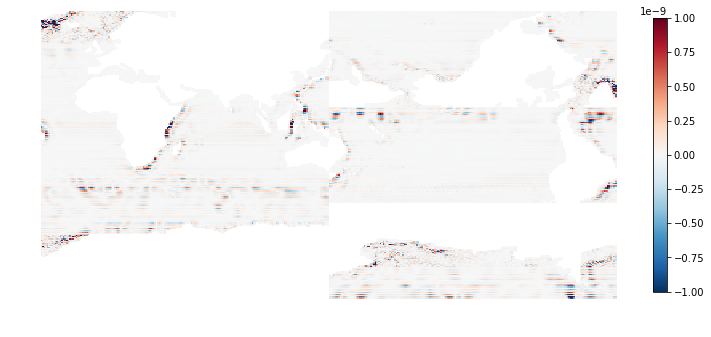

In [37]:
quick_llc_plot(resV*land_mask, add_colorbar=False, axis_off=True, cmap='RdBu_r',vmin=-1e-9,vmax=1e-9)

#### Arctic cap

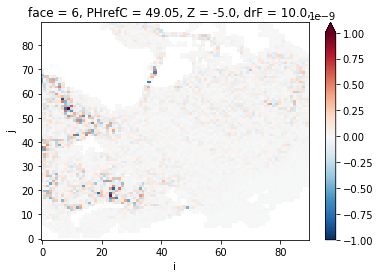

In [38]:
(resV[6]*land_mask[6]).plot(cmap='RdBu_r',vmin=-1e-9,vmax=1e-9)

**Note**: The residuals are larger when doing the calculations on Unix (on Habanero) compared to Mac OS. When running the code on Unix, there is some bias in the horizontal convergence term (`hConvV`), but it is very small.

### Time series for an arbitrarily chosen grid point

In [39]:
f = 1
k = 0
j = 10
i = 10

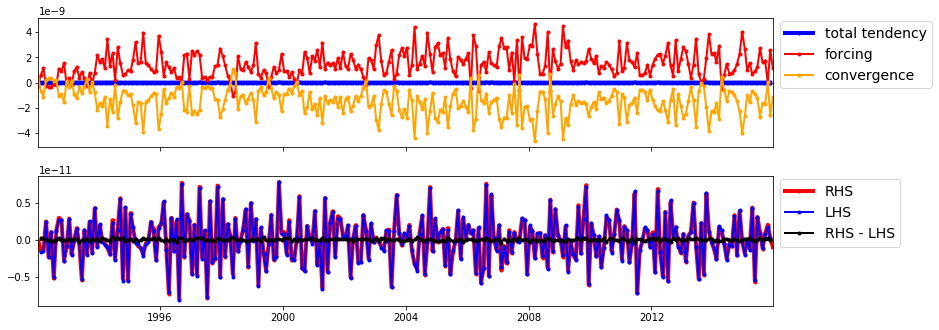

In [41]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(tendV.time, tendV[:,f,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcV.time, forcV[:,f,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(ConvV.time, ConvV[:,f,k,j,i], lw=2, color='orange', marker='.',label='convergence')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(totalV.time, totalV[:,f,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendV.time, tendV[:,f,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendV.time, totalV[:,f,k,j,i]-tendV[:,f,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)
plt.show()

### Verical profiles for an arbitrarily chosen grid point

In [42]:
t = 1

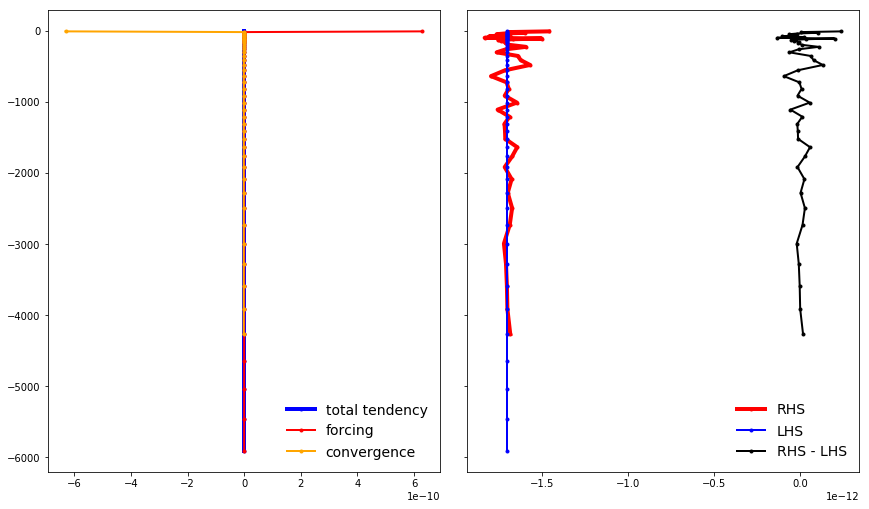

In [43]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendV[t,f,:,j,i],tendV.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcV[t,f,:,j,i],forcV.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(ConvV[t,f,:,j,i],ConvV.Z, lw=2, color='orange', marker='.',label='convergence')
plt.legend(loc='lower right',frameon=False,fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(totalV[t,f,:,j,i],totalV.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendV[t,f,:,j,i],tendV.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalV[t,f,:,j,i]-tendV[t,f,:,j,i],totalV.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower right',frameon=False,fontsize=14)

plt.show()

## Evaluating the heat budget
$$G^{\theta,tot} = G^{\theta,adv} + G^{\theta,forc} + G^{\theta,diff}$$
$$\frac{\partial(s^*\theta)}{\partial t} = -\nabla_{z^*}(s^*\,\theta\,{\bf v_{res}}) - \frac{\partial(\theta\,w_{res})}{\partial z^*} + s^*\,F_{\theta} + s^*\,D_{\theta}$$

### Total tendency
- THETA: Potential Temperature (degC)

In [33]:
# Load snapshots of theta
THETAsnp = ds.THETA_snp

In [34]:
# Calculate the s∗theta term
HCsnp = (THETAsnp*(1+ETANsnp/Depth)).transpose('time_snp','face','k','j','i')

In [35]:
# Total tendency (degC/s)
tendH = grid.diff(HCsnp, 'T', boundary='fill', fill_value=0.0)/dt

# Add coordinates
tendH['Depth'] = ds.Depth
tendH['XC'] = ds.XC
tendH['YC'] = ds.YC
tendH['Z'] = ds.Z
tendH['rA'] = ds.rA
tendH['PHrefC'] = ds.PHrefC
tendH['drF'] = ds.drF
tendH['hFacC'] = ds.hFacC

tendH = xr.concat([np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[0]).expand_dims('time'),tendH,
                   np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[-1]).expand_dims('time')],
                  dim='time').transpose('time','face','k','j','i')

### Forcing
- TFLUX: total heat flux (match heat-content variations) (W/m^2)
- oceQsw: net Short-Wave radiation (+=down) (W/m^2)

In [36]:
# Load monthly averages of heat flux and shortwave radiation
TFLUX = ds.TFLUX
oceQsw = ds.oceQsw

#### Defining terms needed for evaluating surface heat forcing

In [37]:
Z = ds.Z.load()
RF = np.concatenate([ds.Zp1.values[:-1],[np.nan]])

**Note**: `Z` and `Zp1` are used in deriving surface heat penetration. MATLAB code uses `RF` from `mygrid` structure.

In [38]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [39]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [40]:
# Save q1 and q2 as xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

#### Compute vertically penetrating flux

In [41]:
# Surface heat flux (below the surface)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw).transpose('time','face','k','j','i')

In [42]:
# Surface heat flux (at the sea surface)
forcH_surf = ((TFLUX - (1-(q1[0]-q2[0]))*oceQsw)*mskC[0]).transpose('time','face','j','i').assign_coords(k=0).expand_dims('k')

In [43]:
forcH = xr.concat([forcH_surf,forcH_subsurf[:,:,1:]], dim='k').transpose('time','face','k','j','i')

#### Add geothermal heat flux
Geothermal flux needs to be a three dimensional field since the sources are distributed along the ocean floor at various depths. This requires a three dimensional mask.

In [44]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)

In [45]:
mskC_shifted.values[-1,:,:,:] = 0
mskb = mskC - mskC_shifted

In [46]:
# Create 3d field of geothermal heat flux
geoflx3d = ds.GEOFLX * mskb.transpose('face','k','j','i')
GEOFLX = geoflx3d.transpose('face','k','j','i')

In [47]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
forcH = ((forcH + GEOFLX)/(rhoconst*c_p))/(hFacC*drF)

### Advection
#### Horizontal convergence
- ADVx_TH: U Comp. Advective Flux of Pot.Temperature (degC m^3/s)
- ADVy_TH: V Comp. Advective Flux of Pot.Temperature (degC m^3/s)

In [48]:
ADVx_TH = ds.ADVx_TH
ADVy_TH = ds.ADVy_TH

In [49]:
ADVxy_diff = grid.diff_2d_vector({'X' : ADVx_TH, 'Y' : ADVy_TH}, boundary = 'fill')

In [50]:
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']

In [51]:
# Convergence of horizontal advection (degC/s)
adv_hConvH = (-(ADVx_diffx + ADVy_diffy)/vol).transpose('time','face','k','j','i')

#### Vertical convergence
- ADVr_TH: Vertical Advective Flux of Pot.Temperature (degC m^3/s)

In [52]:
# Load monthly averages of vertical advective flux
ADVr_TH = ds.ADVr_TH.transpose('time','face','k_l','j','i')

For `ADVr_TH`, `DFrE_TH` and `DFrI_TH`, we need to make sure that sequence of dimensions are consistent. When loading the fields use `.transpose('time','face','k_l','j','i')`. Otherwise, the divergences will be not correct (at least for face = 12).

In [53]:
# Convergence of vertical advection (degC/s)
adv_vConvH = (grid.diff(ADVr_TH, 'Z', boundary='fill')/vol).transpose('time','face','k','j','i')

The heat budget only balances when the sea surface forcing is not added to the vertical advective flux (at the air-sea interface). This is different from the volume and salinity budget.

### Diffusion
#### Horizontal convergence
- DFxE_TH: U Comp. Diffusive Flux of Pot.Temperature (degC m^3/s)
- DFyE_TH: V Comp. Diffusive Flux of Pot.Temperature (degC m^3/s)

In [54]:
# Load monthly averages of diffusive fluxes
DFxE_TH = ds.DFxE_TH
DFyE_TH = ds.DFyE_TH

In [55]:
DFxyE_diff = grid.diff_2d_vector({'X' : DFxE_TH, 'Y' : DFyE_TH}, boundary = 'fill')

In [56]:
DFxE_diffx = DFxyE_diff['X']
DFyE_diffy = DFxyE_diff['Y']

In [57]:
# Convergence of horizontal diffusion (degC/s)
dif_hConvH = (-(DFxE_diffx + DFyE_diffy)/vol).transpose('time','face','k','j','i')

#### Vertical convergence
- DFrE_TH: Vertical Diffusive Flux of Pot.Temperature (Explicit part) (degC m^3/s)
- DFrI_TH: Vertical Diffusive Flux of Pot.Temperature (Implicit part) (degC m^3/s)

In [58]:
# Load monthly averages of vertical diffusive fluxes
DFrE_TH = ds.DFrE_TH.transpose('time','face','k_l','j','i')
DFrI_TH = ds.DFrI_TH.transpose('time','face','k_l','j','i')

In [59]:
# Convergence of vertical diffusion (degC/s)
dif_vConvH = ((grid.diff(DFrE_TH, 'Z', boundary='fill') + \
              grid.diff(DFrI_TH, 'Z', boundary='fill'))/vol).transpose('time','face','k','j','i')

### Total convergences

In [60]:
# Total convergence of advective flux
adv_ConvH = adv_hConvH + adv_vConvH

# Total convergence of diffusive flux
dif_ConvH = dif_hConvH + dif_vConvH

# Total convergence
ConvH = adv_ConvH + dif_ConvH

### Total tendency

In [61]:
totalH = ConvH + forcH

### Map accumulated residual in heat budget 

In [62]:
resH = (totalH-tendH).sum(dim='k').sum(dim='time')

In [63]:
%time resH.load()

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 13min 38s, sys: 53.7 s, total: 14min 32s
Wall time: 15min 7s


<xarray.DataArray (face: 13, j: 90, i: 90)>
array([[[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        ...,
        [ 2.969346e-12, -1.723363e-12, ..., -4.595937e-12, -5.914870e-12],
        [ 6.446415e-12,  1.130588e-12, ...,  1.666690e-12,  2.918909e-12]],

       [[-3.691685e-12, -2.427325e-12, ...,  5.044332e-12, -2.719160e-12],
        [ 7.445730e-12, -8.827316e-12, ..., -3.826694e-12, -3.532785e-13],
        ...,
        [ 4.627329e-11, -1.166978e-10, ...,  1.434771e-10, -3.470037e-11],
        [ 4.726566e-11,  8.853018e-11, ...,  0.000000e+00,  3.942060e-11]],

       ...,

       [[ 9.394216e-12, -3.520943e-11, ...,  2.939644e-12, -4.128913e-12],
        [-2.432062e-11,  1.180182e-10, ...,  2.877817e-11,  2.822458e-11],
        ...,
        [ 1.436032e-11,  4.975053e-11, ..., -7.866418e-13,  1.598336e-12],
        [ 1.003460e-11, -3.525316e-11, ..., -9.843239e-12,  1.757399e-11]],

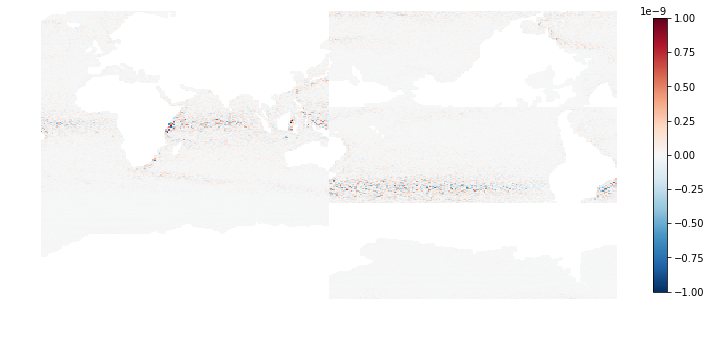

In [66]:
quick_llc_plot(resH*land_mask, add_colorbar=False, axis_off=True, cmap='RdBu_r',vmin=-1e-9,vmax=1e-9)

#### Arctic cap

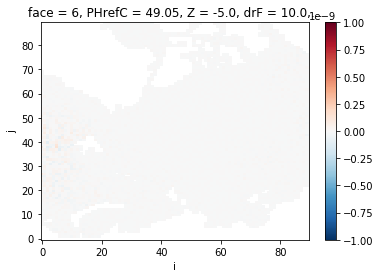

In [67]:
(resH[6]*land_mask[6]).plot(cmap='RdBu_r',vmin=-1e-9,vmax=1e-9)

### Time series for an arbitrarily chosen grid point

In [68]:
f = 12
k = 1
j = 10
i = 10

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


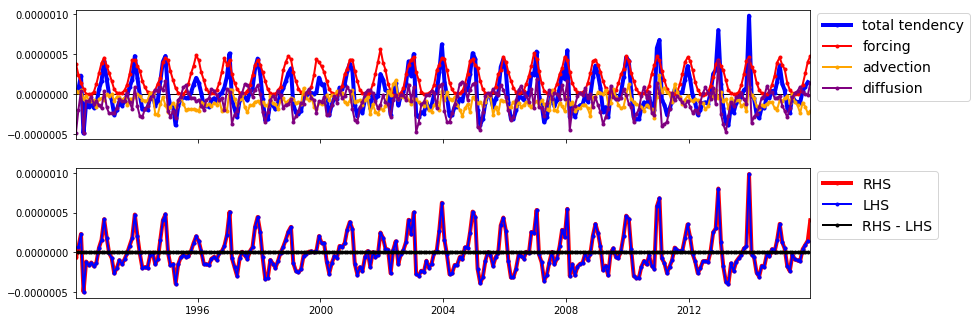

In [70]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(tendH.time, tendH[:,f,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH.time, forcH[:,f,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH.time, adv_ConvH[:,f,k,j,i], lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH.time, dif_ConvH[:,f,k,j,i], lw=2, color='purple', marker='.',label='diffusion')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(totalH.time, totalH[:,f,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH.time, tendH[:,f,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendH.time, totalH[:,f,k,j,i]-tendH[:,f,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)
plt.show()

### Verical profiles for an arbitrarily chosen grid point

In [71]:
t = 1

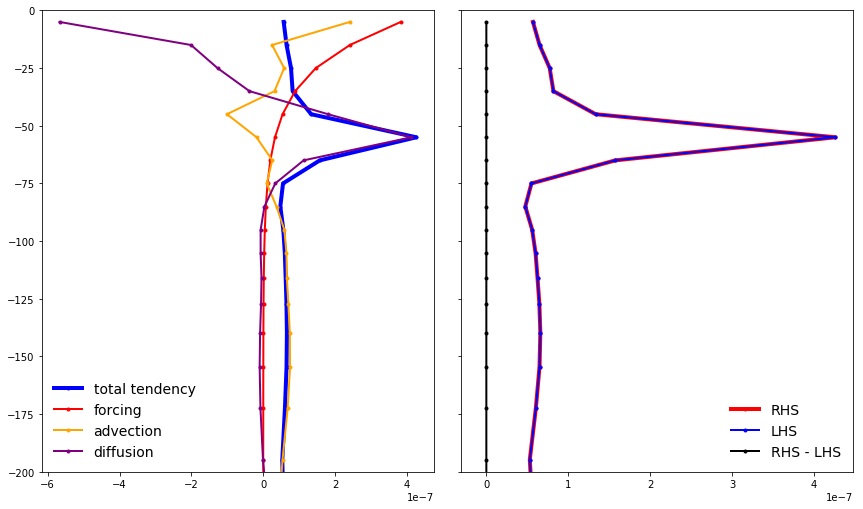

In [72]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendH[t,f,:,j,i],tendH.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH[t,f,:,j,i],forcH.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH[t,f,:,j,i],adv_ConvH.Z, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH[t,f,:,j,i],dif_ConvH.Z, lw=2, color='purple', marker='.',label='diffusion')
plt.legend(loc='lower left',frameon=False,fontsize=14)
plt.ylim([-200,0])

plt.subplot(1, 2, 2)
plt.plot(totalH[t,f,:,j,i],totalH.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH[t,f,:,j,i],tendH.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalH[t,f,:,j,i]-tendH[t,f,:,j,i],tendH.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower right',frameon=False,fontsize=14)
plt.ylim([-200,0])

plt.show()

## Evaluating the salt budget
$$G^{S,tot} = G^{S,adv} + G^{S,forc} + G^{S,diff}$$
$$\frac{\partial(s^*S)}{\partial t} = -\nabla_{z^*}(s^*\,S\,{\bf v_{res}}) - \frac{\partial(S\,w_{res})}{\partial z^*} + s^*\,F_S + s^*\,D_S$$

### Total tendency
- SALT: Salinity (psu)

In [32]:
# Load salinity snapshot
SALTsnp = ds.SALT_snp

In [33]:
# Calculate s*S term
sSALT = (SALTsnp*(1+ETANsnp/Depth)).transpose('time_snp','face','k','j','i')

In [34]:
# Total tendency (psu/s)
tendS = grid.diff(sSALT, 'T', boundary='fill', fill_value=0.0)/dt

# Add coordinates
tendS['Depth'] = ds.Depth
tendS['XC'] = ds.XC
tendS['YC'] = ds.YC
tendS['Z'] = ds.Z
tendS['rA'] = ds.rA
tendS['PHrefC'] = ds.PHrefC
tendS['drF'] = ds.drF
tendS['hFacC'] = ds.hFacC

tendS = xr.concat([np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[0]).expand_dims('time'),tendS,
                   np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[-1]).expand_dims('time')],
                  dim='time').transpose('time','face','k','j','i')

### Forcing
- SFLUX: total salt flux (match salt-content variations) (g/m^2/s)
- oceSPtnd: salt tendency due to salt plume flux (g/m^2/s)

In [35]:
# Load monthly averaged SFLUX and oceSPtnd
SFLUX = ds.SFLUX.assign_coords(k=0).expand_dims('k')
oceSPtnd = ds.oceSPtnd.transpose('time','face','k','j','i')

`SFLUX` and `oceSPtnd` is given in g/m^2/s. Dividing by density and corresponding vertical length scale (`drF`) results in g/kg/s, which is the same as psu/s.

In [36]:
# Surface salt flux (psu/s)
forcS_surf = ((SFLUX/rhoconst)/(hFacC*drF)).transpose('time','face','k','j','i')

In [37]:
# Salt tendency (psu/s)
forcS_tend = ((oceSPtnd/rhoconst)/(hFacC*drF)).transpose('time','face','k','j','i')

In [38]:
forcS = xr.concat([forcS_surf+forcS_tend,forcS_tend[:,:,1:]], dim='k').transpose('time','face','k','j','i')

### Advection
#### Horizontal convergence
- ADVx_SLT: U Comp. Advective Flux of Salinity (psu m^3/s)
- ADVy_SLT: V Comp. Advective Flux of Salinity (psu m^3/s)

In [39]:
# Load monthly averaged advective fluxes
ADVx_SLT = ds.ADVx_SLT
ADVy_SLT = ds.ADVy_SLT

In [40]:
ADVxy_SLT_diff = grid.diff_2d_vector({'X' : ADVx_SLT, 'Y' : ADVy_SLT}, boundary = 'fill')

In [41]:
ADVx_SLT_diffx = ADVxy_SLT_diff['X']
ADVy_SLT_diffy = ADVxy_SLT_diff['Y']

In [42]:
# Convergence of horizontal advection (psu/s)
adv_hConvS = (-(ADVx_SLT_diffx + ADVy_SLT_diffy)/vol).transpose('time','face','k','j','i')

#### Vertical convergence
- ADVr_SLT: Vertical Advective Flux of Salinity (psu m^3/s)

In [43]:
# Load monthly averaged vertical advective flux
ADVr_SLT = ds.ADVr_SLT.transpose('time','face','k_l','j','i')

The salt budget only balances when the sea surface forcing is not added to the vertical salt flux (at the air-sea interface). This is different from the volume and salinity budget.

In [44]:
# Convergence of vertical advection (psu/s)
adv_vConvS = (grid.diff(ADVr_SLT, 'Z', boundary='fill')/vol).transpose('time','face','k','j','i')

### Diffusion
#### Horizontal convergence
- DFxE_SLT: U Comp. Diffusive Flux of Salinity (psu m^3/s)
- DFyE_SLT: V Comp. Diffusive Flux of Salinity (psu m^3/s)

In [45]:
# Load monthly averaged horizontal diffusive fluxes
DFxE_SLT = ds.DFxE_SLT
DFyE_SLT = ds.DFyE_SLT

In [46]:
DFxyE_SLT_diff = grid.diff_2d_vector({'X' : DFxE_SLT, 'Y' : DFyE_SLT}, boundary = 'fill')

In [47]:
DFxE_SLT_diffx = DFxyE_SLT_diff['X']
DFyE_SLT_diffy = DFxyE_SLT_diff['Y']

In [48]:
# Convergence of horizontal diffusion (psu/s)
dif_hConvS = (-(DFxE_SLT_diffx + DFyE_SLT_diffy)/vol).transpose('time','face','k','j','i')

#### Vertical convergence
- DFrE_SLT: Vertical Diffusive Flux of Salinity (Explicit part) (psu m^3/s)
- DFrI_SLT: Vertical Diffusive Flux of Salinity (Implicit part) (psu m^3/s)

In [49]:
# Load monthly averaged vertical diffusive fluxes
DFrE_SLT = ds.DFrE_SLT.transpose('time','face','k_l','j','i')
DFrI_SLT = ds.DFrI_SLT.transpose('time','face','k_l','j','i')

In [50]:
# Convergence of vertical diffusion (psu/s)
dif_vConvS = ((grid.diff(DFrE_SLT, 'Z', boundary='fill') + \
               grid.diff(DFrI_SLT, 'Z', boundary='fill'))/vol).transpose('time','face','k','j','i')

### Total convergences

In [51]:
# Total convergence of advective flux
adv_ConvS = adv_hConvS + adv_vConvS

# Total convergence of diffusive flux
dif_ConvS = dif_hConvS + dif_vConvS

# Total convergence
ConvS = adv_ConvS + dif_ConvS

### Total tendency

In [52]:
totalS = ConvS + forcS

### Plot accumulated residual in salt budget 

In [103]:
resS = (totalS-tendS).sum(dim='k').sum(dim='time')

In [104]:
%time resS.load()

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 15min 53s, sys: 1min 3s, total: 16min 56s
Wall time: 20min 43s


<xarray.DataArray (face: 13, j: 90, i: 90)>
array([[[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        ...,
        [ 4.400504e-12,  1.159839e-10, ...,  2.778236e-11, -4.401382e-11],
        [-1.141566e-10,  1.791842e-10, ...,  9.564881e-11, -5.506946e-11]],

       [[ 1.640552e-10,  4.075139e-11, ...,  6.995920e-12,  1.263451e-11],
        [-8.713690e-11,  6.122237e-11, ..., -6.508765e-11,  5.432079e-11],
        ...,
        [-3.290656e-12,  1.335641e-11, ...,  5.981190e-11, -2.220404e-10],
        [ 7.472398e-11,  4.154808e-11, ...,  0.000000e+00,  2.187758e-10]],

       ...,

       [[ 6.095049e-11,  2.675748e-10, ...,  1.331915e-10, -1.185759e-10],
        [-3.526056e-11, -1.584913e-10, ..., -6.160221e-11,  1.409948e-10],
        ...,
        [ 6.360342e-11, -1.587420e-12, ..., -1.059855e-10, -3.866451e-11],
        [-1.532679e-11, -1.717274e-11, ...,  1.868151e-10, -3.806806e-11]],

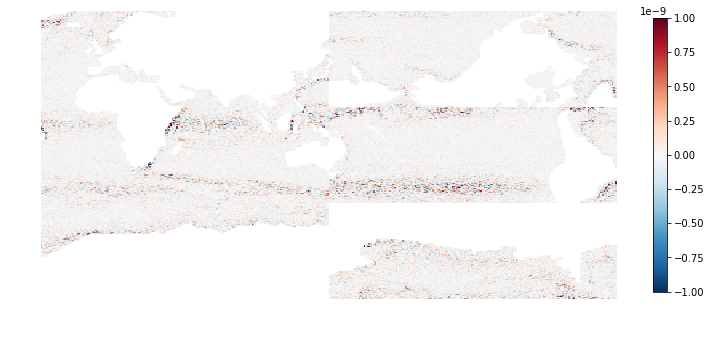

In [106]:
quick_llc_plot(resS*land_mask, add_colorbar=False, axis_off=True, cmap='RdBu_r',vmin=-1e-9,vmax=1e-9)

#### Arctic cap

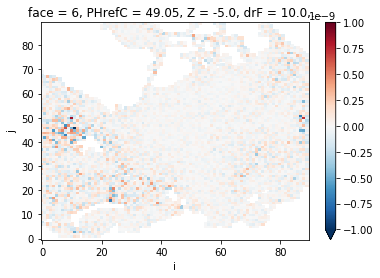

In [107]:
(resS[6]*land_mask[6]).plot(cmap='RdBu_r',vmin=-1e-9,vmax=1e-9)

### Time series for an arbitrarily chosen grid point

In [108]:
f = 0
k = 1
j = 75
i = 10

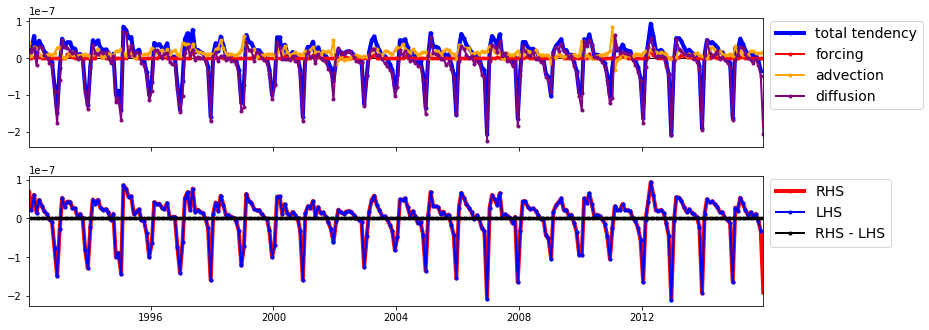

In [109]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(tendS.time, tendS[:,f,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcS.time, forcS[:,f,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvS.time, adv_ConvS[:,f,k,j,i], lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvS.time, dif_ConvS[:,f,k,j,i], lw=2, color='purple', marker='.',label='diffusion')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(totalS.time, totalS[:,f,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendS.time, tendS[:,f,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendS.time, totalS[:,f,k,j,i]-tendS[:,f,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)
plt.show()

### Verical profiles for an arbitrarily chosen grid point

In [110]:
t = 10

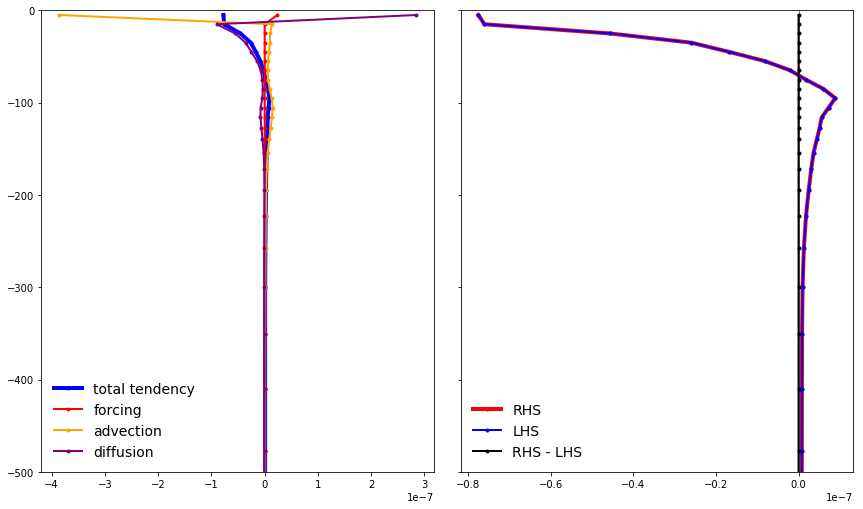

In [111]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendS[t,f,:,j,i], tendS.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcS[t,f,:,j,i], forcS.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvS[t,f,:,j,i], adv_ConvS.Z, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvS[t,f,:,j,i], dif_ConvS.Z, lw=2, color='purple', marker='.',label='diffusion')
plt.legend(loc='lower left', frameon=False, fontsize=14)
plt.ylim([-500,0])
#plt.xlim([-2e-10,2e-10])

plt.subplot(1, 2, 2)
plt.axvline(x=0, ymin=0, ymax=1, linewidth=0.5, color = 'k')
plt.plot(totalS[t,f,:,j,i], totalS.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendS[t,f,:,j,i], tendS.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalS[t,f,:,j,i]-tendS[t,f,:,j,i], tendS.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower left',frameon=False,fontsize=14)
plt.ylim([-500,0])
#plt.xlim([-2e-10,2e-10])

plt.show()

## Evaluating the salinity budget
$$G^{Sln,tot} = G^{Sln,adv} + G^{Sln,forc} + G^{Sln,diff}$$
$$\frac{\partial S}{\partial t} = \frac{1}{s^*} \left[S\,\nabla_{z^*}(s^*\,{\bf v}) + S\,\frac{\partial w}{\partial z^*} - \nabla_{z^*}(s^*\,S\,{\bf v_{res}}) - \frac{\partial S\,w_{res}}{\partial z^*}\right] + D_S + F_S - S\,F$$

### Scale factor
- Depth: Ocean_depth (m)
- ETAN: Surface Height Anomaly (m)

In [53]:
# Load monthly averaged surface height anomaly
ETAN = ds.ETAN

In [54]:
# Scale factor
rstarfac = ((Depth + ETAN)/Depth).transpose('time','face','j','i')

### Total tendency

In [55]:
# Total tendency (psu/s)
tendSln = grid.diff(SALTsnp, 'T', boundary='fill', fill_value=0.0)/dt

# Add coordinates
tendSln['Depth'] = ds.Depth
tendSln['XC'] = ds.XC
tendSln['YC'] = ds.YC
tendSln['Z'] = ds.Z
tendSln['rA'] = ds.rA
tendSln['PHrefC'] = ds.PHrefC
tendSln['drF'] = ds.drF
tendSln['hFacC'] = ds.hFacC

tendSln = xr.concat([np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[0]).expand_dims('time'),tendSln,
                     np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[-1]).expand_dims('time')],
                    dim='time').transpose('time','face','k','j','i')

### Forcing
The forcing term is comprised of both salt flux (`forcS`) and volume (i.e., freshwater) flux (`forcV`).
- SALT: Salinity (psu)

In [56]:
# Load monthly averaged salinity fields
SALT = ds.SALT.transpose('time','face','k','j','i')

In [57]:
# Sea surface forcing for salinity (psu/s)
forcSln = ((-SALT*forcV + forcS)/rstarfac).transpose('time','face','k','j','i')

### Advection
#### Horizontal convergence

In [58]:
adv_hConvSln = ((-SALT*hConvV + adv_hConvS)/rstarfac).transpose('time','face','k','j','i')

#### Vertical convergence

In [59]:
adv_vConvSln = ((-SALT*vConvV + adv_vConvS)/rstarfac).transpose('time','face','k','j','i')

### Diffusion
#### Horizontal convergence

In [60]:
dif_hConvSln = dif_hConvS/rstarfac

#### Vertical convergence

In [61]:
dif_vConvSln = dif_vConvS/rstarfac

### Total convergences

In [62]:
# Total convergence of advective flux
adv_ConvSln = adv_hConvSln + adv_vConvSln

# Total convergence of diffusive flux
dif_ConvSln = dif_hConvSln + dif_vConvSln

# Total convergence
ConvSln = adv_ConvSln + dif_ConvSln

### Total tendency

In [63]:
totalSln = ConvSln + forcSln

### Plot Accumulated residual in salinity budget 

In [64]:
resSln = (totalSln-tendSln).sum(dim='k').sum(dim='time')

In [ ]:
%time resSln.load()

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.scheduler - ERROR - Failed to connect to worker 'tcp://10.23.235.8:36415': Timed out trying to connect to 'tcp://10.23.235.8:36415' after 10 s: connect() didn't finish in time
distributed.scheduler - ERROR - Failed to connect to worker 'tcp://10.20.2.8:43449': Timed out trying to connect to 'tcp://10.20.2.8:43449' after 10 s: connect() didn't finish in time
distributed.stealing - ERROR - 'tcp://10.20.2.8:43449'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/stealing.py", line 177, in move_task_request
    self.scheduler.worker_comms[victim.address].send(
KeyError: 'tcp://10.20.2.8:43449'
distributed.utils - ERROR - 'tcp://10.20.2.8:43449'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/dist

In [ ]:
quick_llc_plot(resSln*land_mask, add_colorbar=False, axis_off=True, cmap='RdBu_r')#,vmin=-1e-9,vmax=1e-9)

#### Arctic cap

In [ ]:
(resSln[6]*land_mask[6]).plot(cmap='RdBu_r',vmin=-1e-9,vmax=1e-9)

In [ ]:
resSln[:,6,0:10,:30,70:].plot(cmap='RdBu_r')

In [ ]:
resSln[:,6,0:10,15,75]

### Time series for an arbitrarily chosen grid point

In [65]:
f = 6
k = 1
j = 15
i = 75

RuntimeError: error during blosc decompression: -1

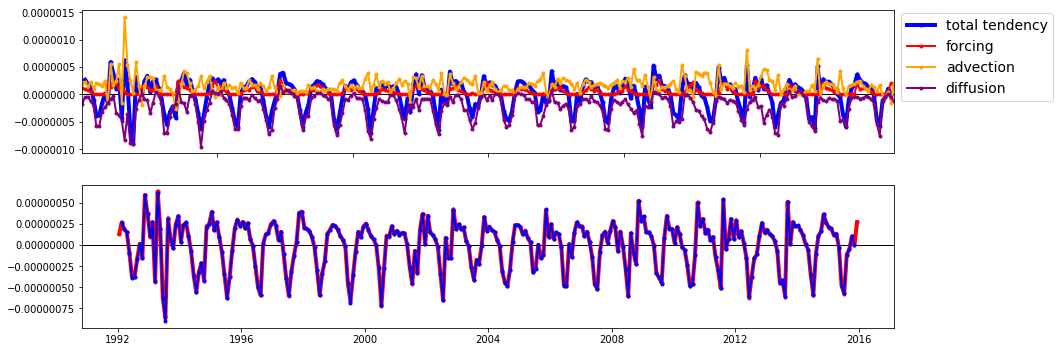

In [67]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(tendSln.time, tendSln[:,f,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcSln.time, forcSln[:,f,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvSln.time, adv_ConvSln[:,f,k,j,i], lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvSln.time, dif_ConvSln[:,f,k,j,i], lw=2, color='purple', marker='.',label='diffusion')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(totalSln.time, totalSln[:,f,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendSln.time, tendSln[:,f,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendSln.time, totalSln[:,f,k,j,i]-tendSln[:,f,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)
plt.show()

### Verical profiles for an arbitrarily chosen grid point

In [68]:
t = 18

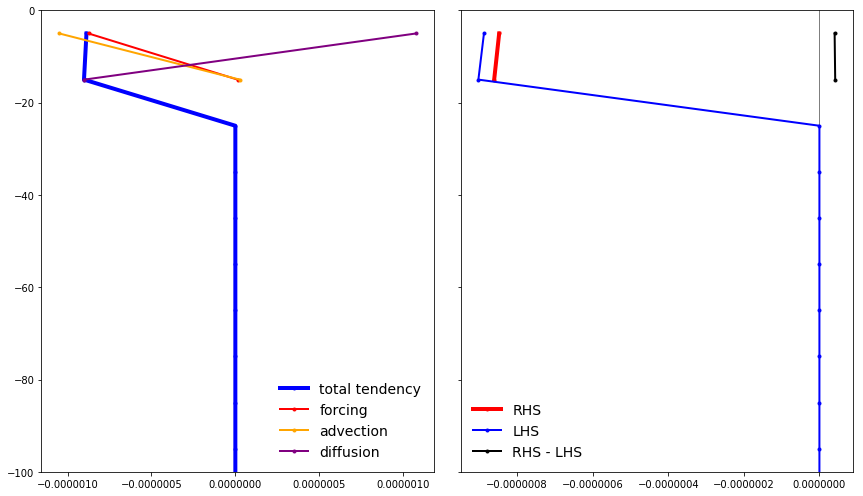

In [69]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendSln[t,f,:,j,i],tendSln.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcSln[t,f,:,j,i],forcSln.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvSln[t,f,:,j,i],adv_ConvSln.Z, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvSln[t,f,:,j,i],dif_ConvSln.Z, lw=2, color='purple', marker='.',label='diffusion')
plt.legend(loc='lower right',frameon=False,fontsize=14)
plt.ylim([-100,0])

plt.subplot(1, 2, 2)
plt.axvline(x=0, ymin=0, ymax=1, linewidth=0.5, color = 'k')
plt.plot(totalSln[t,f,:,j,i],totalSln.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendSln[t,f,:,j,i],tendSln.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalSln[t,f,:,j,i]-tendSln[t,f,:,j,i],tendSln.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower left',frameon=False,fontsize=14)
plt.ylim([-100,0])

plt.show()